### Imports:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, InputLayer, Conv2D, UpSampling2D, DepthwiseConv2D
from tensorflow.keras.layers import Flatten, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
from tensorflow.keras.utils import plot_model
from math import ceil
import random
import cv2
from skimage import io, color

### Model Configurations:

In [ ]:
# May be able to turn this off after adjustments
tf.config.run_functions_eagerly(True)

### Data Preparation for the Model:

##### Get the data from the saved files that has been previously processed in ReplicasProcessingScript.py:

In [2]:
# Open the file that train_set is stored in as f
with open('train_set.npy', 'rb') as f:

    # Load and get a handle for train_set
    train_set = np.load(f)

# Open the file that train_set is stored in as f
with open('test_set.npy', 'rb') as f:
    
    # Load and get a handle for test_set
    test_set = np.load(f)

##### Prepare the train_set for he model:

In [3]:
train_set[0].shape

(20, 65, 99)

In [4]:
# Prepare the input values from the training set (used for model training)
X = train_set[0]
X = ((X.reshape(X.shape[0],X.shape[1],X.shape[2],1)))
# X = X[:,:64,:96,:]
X = X[:,:65,:99,:]
X.shape

(20, 65, 99, 1)

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<AxesSubplot:>

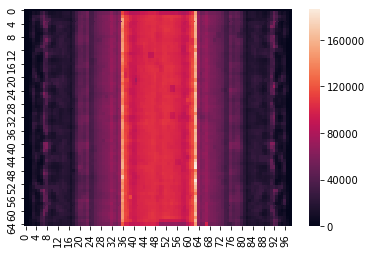

In [5]:
# View the training data as a heatmap of occupancy values
import seaborn as sns
sns.heatmap(pd.DataFrame(X[1,:,:,0]))

In [6]:
# Prepare the target values from the training set (used for model training)
Y = train_set[1]
Y = ((Y.reshape(Y.shape[0],Y.shape[1],Y.shape[2],1)))
# Y = Y[:,:64,:96,:]
Y = Y[:,:65,:99,:]
Y.shape

(20, 65, 99, 1)

##### Prepare the test_set for  the model:

In [7]:
# Prepare the input values from the test set (used for model evaluation)
X2 = test_set[0]
X2 = ((X2.reshape(X2.shape[0],X2.shape[1],X2.shape[2],1)))
# X2 = X2[:,:64,:96,:]
X2 = X2[:,:65,:99,:]
X2.shape

(8, 65, 99, 1)

In [8]:
# Prepare the target values from the test set (used for model evaluation)
Y2 = test_set[1]
Y2 = ((Y2.reshape(Y2.shape[0],Y2.shape[1],Y2.shape[2],1)))
# Y2 = Y2[:,:64,:96,:]
Y2 = Y2[:,:65,:99,:]
Y2.shape

(8, 65, 99, 1)

### Model Preparation
experiments still occuring...

ATTEMPT 1: (failed)

In [8]:
# For model input ?
model6 = VGG16(weights='imagenet', include_top=False, input_shape=(65,99,3))

# Sequential model constructor initialization
model = Sequential()

# This is simply defining the input layer and its shape
model.add(InputLayer(input_shape=(X.shape[1], X.shape[2], 1)))

# A dense layer of 3 neurons, 1 unit for each input (each channel in this case..or each 64x96 matrix) ...need to use 3 because VGG16 requires 3 input channels..this is a main problem
model.add(layers.Dense(units=3))

# The inputs are coming from models or the VGG16 pretrained model, we do not want this
model.add(Model(inputs=model6.inputs, outputs=model6.layers[-10].output))

# Adds repeating rows/columns in the input to this layer. Rows/column repeats are determined by the size parameter
model.add(UpSampling2D(size=(2,2)))

# Adds repeating rows/columns in the input to this layer. Rows/column repeats are determined by the size parameter
model.add(UpSampling2D(size=(2,2)))

# Specifies 2d depthwise convolution of inputs whose kernel size is 32x32, strides is (2,2) for each movement of kernel/filter, the input gets passed through a tanh filter before 
# convolution (values come through as -1 to 1), and the padding as 'same'  results in padding with zeros evenly to the left/right or
# up/down of the input such that output has the same height/width dimension as the input. 
model.add(DepthwiseConv2D(32,(2,2), activation='tanh', padding='same'))

# Adds repeating rows/columns in the input to this layer. Rows/column repeats are determined by the size parameter
model.add(UpSampling2D(size=(2,2)))

# Specifies 2d depthwise convolution of inputs whose kernel size is 32x32, strides is (2,2) for each movement of kernel/filter, the input gets passed through a tanh filter before 
# convolution (values come through as -1 to 1), and the padding as 'same'  results in padding with zeros evenly to the left/right or
# up/down of the input such that output has the same height/width dimension as the input. 
# The convolution operates by - splitting the input to individual channels, convolve each input with the layer's kernel/filter(called depthwise kernel), and stack convolved outputs together
# along the channel's axis ..unlike regular 2d convolution, does not mix information across different outputs
model.add(DepthwiseConv2D(32,(2,2), activation='tanh', padding='same'))

# Passing information from the convolution that gets converted to 0 until it reaches some minimum value, then becomes that value (is this correct?)
model.add(layers.ReLU(0.3))

# Drops some neurons out to assist in overfitting (correct?)
model.add(layers.Dropout(0.4))

# Adds repeating rows/columns in the input to this layer. Rows/column repeats are determined by the size parameter
model.add(UpSampling2D(size=(2,2)))

# Adds repeating rows/columns in the input to this layer. Rows/column repeats are determined by the size parameter
model.add(UpSampling2D(size=(2,2)))

# Specifies 2d depthwise convolution of inputs whose kernel size is 32x32, strides is (2,2) for each movement of kernel/filter, the input gets passed through a tanh filter before 
# convolution (values come through as -1 to 1), and the padding as 'same'  results in padding with zeros evenly to the left/right or
# up/down of the input such that output has the same height/width dimension as the input. 
model.add(DepthwiseConv2D(2,(2,2), activation='tanh', padding='same'))

# Activation function that cutsoff values at 0.3?
model.add(layers.ReLU(0.3))

# Layer to prevent overfitting, drops some neurons
model.add(layers.Dropout(0.2))

# Adds repeating rows/columns in the input to this layer. Rows/column repeats are determined by the size parameter
model.add(UpSampling2D(size=(2,2)))

# Another value filter
model.add(layers.ReLU(0.3))

# Another overfitting balancer
model.add(layers.Dropout(0.2))

# ?
model.add(AveragePooling2D(pool_size = (2,2)))

# passes the previous input to 2 neurons in this new hidden layer (This is the output layer..the output is 2 neurons of information)
model.add(layers.Dense(units=2))

# Get a summary of the model
print(model.summary())

# This will need to be optimized...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 65, 99, 3)         6         
_________________________________________________________________
functional_1 (Functional)    (None, 16, 24, 256)       1735488   
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 32, 48, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 64, 96, 256)       0         
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 32, 48, 256)       262400    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 64, 96, 256)       0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 32, 48, 256)       2

ATTEMPT 2:

In [21]:
# Constructing a simple tensorflow/keras CNN:


# For model input ?
vgg_model = VGG16(weights=None, include_top=False, input_shape=(64,96,3))


weights_file='../../Machine Learning/Data/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'


vgg_model.load_weights(weights_file)

for layer in vgg_model.layers:
     layer.trainable = False

vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 24, 128)       0     

In [24]:
last_layer = vgg_model.get_layer('block5_pool')
last_output = last_layer.output


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

vgg_model = Model(vgg_model.input, x) 

vgg_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 24, 128)      

##### Prepare the optimizer for the model:
experiments still occuring...

(This will need to be optimized using something like a random search or grid search ...the optimization graph can be generated like I did for the linear regression blog...)<br>
<br>
ATTEMPT 1: (failed) 

In [11]:
def adam_optimizer():
    return Adam(lr = 0.001, beta_1=0.99, beta_2=0.999)
model.compile(loss='mape', optimizer = adam_optimizer(), metrics=['accuracy'])

ATTEMPT 2:

In [25]:
from tensorflow.keras.optimizers import RMSprop

In [26]:
model.compile(loss='binary_crossentropy', optimizer = RMSprop(lr=0.0001), metrics=['accuracy'])

##### Train the model with the data
experiments still occuring...
<br>
Result - this will need to be optimized using something like a random search or grid search ...the optimization graph can be generated like I did for the linear regression blog...

ATTEMPT 1: (failed), 11 epochs

In [12]:
model.fit(x=X, y=Y,validation_data=(X2,Y2),batch_size=10, epochs=11)

Epoch 1/11
2/2 [==============================] - 3s 2s/step - loss: 19.8857 - accuracy: 0.4106 - val_loss: 4.1144 - val_accuracy: 0.7325
Epoch 2/11
2/2 [==============================] - 3s 1s/step - loss: 19.5622 - accuracy: 0.4123 - val_loss: 4.5062 - val_accuracy: 0.7325
Epoch 3/11
2/2 [==============================] - 3s 1s/step - loss: 22.5283 - accuracy: 0.4092 - val_loss: 4.7331 - val_accuracy: 0.7325
Epoch 4/11
2/2 [==============================] - 3s 2s/step - loss: 19.2560 - accuracy: 0.4115 - val_loss: 4.5102 - val_accuracy: 0.7325
Epoch 5/11
2/2 [==============================] - 3s 2s/step - loss: 19.1626 - accuracy: 0.4117 - val_loss: 4.4768 - val_accuracy: 0.7325
Epoch 6/11
2/2 [==============================] - 3s 1s/step - loss: 19.1730 - accuracy: 0.4110 - val_loss: 4.3343 - val_accuracy: 0.7325
Epoch 7/11
2/2 [==============================] - 3s 2s/step - loss: 19.4288 - accuracy: 0.4126 - val_loss: 4.3877 - val_accuracy: 0.7326
Epoch 8/11
2/2 [==================

ATTEMPT 2: 11 epochs

Play with batch_size

In [27]:
model.fit(x=X, y=Y,validation_data=(X2,Y2),batch_size=10, epochs=11)

Epoch 1/11
2/2 [==============================] - 3s 2s/step - loss: 19.7770 - accuracy: 0.4137 - val_loss: 4.8965 - val_accuracy: 0.7326
Epoch 2/11
2/2 [==============================] - 3s 2s/step - loss: 19.6664 - accuracy: 0.4111 - val_loss: 4.7617 - val_accuracy: 0.7326
Epoch 3/11
2/2 [==============================] - 4s 2s/step - loss: 19.2685 - accuracy: 0.4107 - val_loss: 4.2381 - val_accuracy: 0.7327
Epoch 4/11
2/2 [==============================] - 3s 2s/step - loss: 19.1851 - accuracy: 0.4122 - val_loss: 4.2238 - val_accuracy: 0.7327
Epoch 5/11
2/2 [==============================] - 3s 2s/step - loss: 19.1181 - accuracy: 0.4138 - val_loss: 4.5623 - val_accuracy: 0.7327
Epoch 6/11
2/2 [==============================] - 3s 1s/step - loss: 19.2784 - accuracy: 0.4124 - val_loss: 4.7182 - val_accuracy: 0.7327
Epoch 7/11
2/2 [==============================] - 3s 2s/step - loss: 19.1594 - accuracy: 0.4116 - val_loss: 4.7216 - val_accuracy: 0.7327
Epoch 8/11
2/2 [==================

<b>UPDATE(7-23-21 5:50pm):</b> 
- The quick way to vgg https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Anomaly_Detection_Image/Anomaly_Detection_Image.ipynb
- The input data https://www.kaggle.com/arunrk7/surface-crack-detection
- The less quick way to vgg with more input files https://www.kaggle.com/kutaykutlu/99-9-acc-resnet50-inceptionv3-vgg16
- for the 2 color channels that go with the grey channel (a and b channels from lab), we can create 2 more dimension to our matrix such that shape is hist.shape=(eta,phi,3)
 - the 1st matrix in (eta,phi,3) as hist[:,:,0] will be the occupancy values in eta,phi. The other 2 chanels hist[:,:,1:3] can be set as matrices of 0 or midpoint values for no color (this still needs to be done)
- The layers in this model output smaller dimensions for predictions, whereas the model in attempt 1 outputs a matrix of values the size we would expect so we can get a pixel by pixel classification value ...either I will have to better understand the sources in the links above and how they visualized their predictions. Or I will have to modify attempt1's model to get better accuracy for class predictions(not that I entirely understand it atm either)
- one of the best simplest examples ive seen of image classification using vgg16

##### Make predictions over the training and testing sets:
experiments still occuring...

In [16]:
train_pred = model.predict(X)
test_pred = model.predict(X2)

# This rescales the data in train_pred, whose minimum and maximum are (train_pred.min(),train_pred.max()) to a scale whose min and max are (0,255)
# check_train=np.interp(train_pred, (train_pred.min(), train_pred.max()), (0,255))
# check_test = np.interp(test_pred, (test_pred.min(),test_pred.max()),(0,255))

# Because we are not predicting colorization, this below few lines doesnt make much sense..except maybe l_channel

# l_channel = X2[20]*255
# a_channel=check_test[20,:,:,0]
# b_channel=check_test[20,:,:,1]

# transfer = cv2.merge([l_channel, a_channel, b_channel])
# transfer = cv2.cvtColor(transfer.astype('uint8'), cv2.COLOR_LAB2BGR)

##### Visualizing the train_pred_df matrix:

In [17]:
train_pred_df = pd.DataFrame(train_pred[0,:,:,0],columns=[f'$\phi$'+str(phival) for phival in range(train_pred[0].shape[1])],index=[r'$\eta$'+str(etaval) for etaval in range(train_pred[0].shape[0])])
train_pred_df

,$\phi$0,$\phi$1,$\phi$2,$\phi$3,$\phi$4,$\phi$5,$\phi$6,$\phi$7,$\phi$8,$\phi$9,...,$\phi$86,$\phi$87,$\phi$88,$\phi$89,$\phi$90,$\phi$91,$\phi$92,$\phi$93,$\phi$94,$\phi$95
$\eta$0,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
$\eta$1,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
$\eta$2,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
$\eta$3,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
$\eta$4,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
$\eta$59,-0.003328,-0.003328,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856
$\eta$60,-0.003327,-0.003327,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002863,-0.002863,-0.002935,-0.002935,-0.002915,-0.002915,-0.002869,-0.002869,-0.002868,-0.002868
$\eta$61,-0.003327,-0.003327,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002863,-0.002863,-0.002935,-0.002935,-0.002915,-0.002915,-0.002869,-0.002869,-0.002868,-0.002868
$\eta$62,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.003199,-0.003199,-0.003199,-0.003199,-0.003199,-0.003199,-0.003199,-0.003199,-0.003199,-0.003199


##### For visualizing the dataframe in standard format:
IMPORTANT: Do not reformat the previous block's code. It will make the format look very poor (very large columns in some cases)

In [22]:
train_pred_df = pd.DataFrame(train_pred[0,:,:,0])
train_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
1,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
2,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
3,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
4,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556


##### What does the heatmap of classification values for this histogram look like, reminder, this visualization is of histogram 0 in the 39 histograms available in train_pred:

In [20]:
import seaborn as sns

/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<AxesSubplot:>

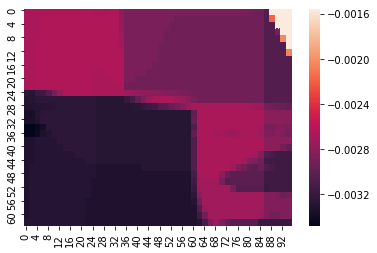

In [23]:
sns.heatmap(train_pred_df)

##### For visualizing the dataframe in standard format - continued

In [28]:
train_pred_df = train_pred_df.stack().reset_index(name='quality_rating').rename(columns={'level_0':r'$\eta$','level_1':r'$\phi$','quality_rating':'quality_rating'})
train_pred_df

,$\eta$,$\phi$,quality_rating
0,0,0,-0.002676
1,0,1,-0.002676
2,0,2,-0.002676
3,0,3,-0.002676
4,0,4,-0.002676
...,...,...,...
6139,63,91,-0.003199
6140,63,92,-0.003199
6141,63,93,-0.003199
6142,63,94,-0.003199


##### View the number of occurences of specific values:

In [30]:
# here, 'tmp = ' affects the output in such a way where it displays properly
tmp = [print('quality_rating:',idV,' num_vals:',val) for val in train_pred_df['quality_rating'].value_counts().sort_index().values for idV in train_pred_df['quality_rating'].value_counts().sort_index().index]

quality_rating: -0.003486313857138157  num_vals: 4
quality_rating: -0.0034848609939217567  num_vals: 4
quality_rating: -0.003469405695796013  num_vals: 4
quality_rating: -0.00346572557464242  num_vals: 4
quality_rating: -0.003448137082159519  num_vals: 4
quality_rating: -0.003421834670007229  num_vals: 4
quality_rating: -0.0033837626688182354  num_vals: 4
quality_rating: -0.0033683795481920242  num_vals: 4
quality_rating: -0.003363735042512417  num_vals: 4
quality_rating: -0.003357174340635538  num_vals: 4
quality_rating: -0.003352866508066654  num_vals: 4
quality_rating: -0.003340932074934244  num_vals: 4
quality_rating: -0.0033280723728239536  num_vals: 4
quality_rating: -0.0033280523493885994  num_vals: 4
quality_rating: -0.003328045830130577  num_vals: 4
quality_rating: -0.003327932208776474  num_vals: 4
quality_rating: -0.003327770158648491  num_vals: 4
quality_rating: -0.0033276649191975594  num_vals: 4
quality_rating: -0.0033275349996984005  num_vals: 4
quality_rating: -0.003326

### Evaluating the model with the test set:

In [267]:
test_pred_df = pd.DataFrame(test_pred[0,:,:,0])
test_pred_df.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
1,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
2,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
3,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
4,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556


In [219]:
test_targets_df = pd.DataFrame(Y2[0,:,:,0])
test_targets_df.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [50]:
test_pred_df.to_numpy().shape

(64, 96)

In [47]:
test_targets_df.to_numpy().shape

(64, 96)

In [268]:
a = np.array([val for i,val in enumerate(test_pred_df.to_numpy())])
a = np.interp(a,(a.min(),a.max()),(0,1))
threshold = 0.8
a = np.where(threshold > a, 0, 1)
a

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [269]:
test_pred_df = pd.DataFrame(a[:,:])
test_pred_df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,1,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
61,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
62,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

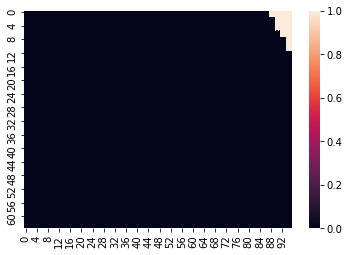

In [270]:
# What the model classified as true - highly dependant on threshold parameter set earlier in the process
#Originally, we have probabilities that values are outliers. Those probabilities are then converted to true for outlier(1) or 0 for non outlier based on the threshold
# I currently believe that if we are having to optimize for a theshold parameter for classification then our predictions will be no better than a statistical formula applied over the
# actual occupancies and returning if it is an outlier or not. ESPECIALLY if we set our threshold based on this formula.
sns.heatmap(test_pred_df)

<AxesSubplot:>

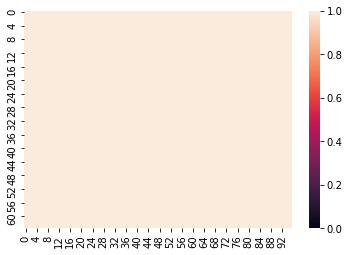

In [220]:
# What the classification should look like for this one
sns.heatmap(test_targets_df,vmin=0,vmax=1)

We now have 2 dataframes that we can construct the...
- TP (small number based on 2 images)
- FP (none)
- TN (none)
- FN (many)
we would likely need to vectorize this data so we would use something like list comprehension to do this

In [264]:
# test_targets_df vectorized
test_pred_df = [test_pred_df.to_numpy()[idx][i] for i in range(test_pred_df.to_numpy().shape[1]) for idx,val in enumerate(test_pred_df.to_numpy())]
test_pred_asvec

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [265]:
Y2_asvec = [test_targets_df.to_numpy()[idy][i] for i in range(test_targets_df.to_numpy().shape[1]) for idy,val in enumerate(test_targets_df.to_numpy())]
Y2_asvec

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Also, its possible to use the inbuilt keras evaluation tool...lol<br>
<b>IMPORTANT: Results HEAVILY dependant on the threshold value that is set for classification!</b>

### Using the model to predict quality values for an input histogram:

##### Imports:

In [190]:
import seaborn as sns

##### Settings:

In [232]:
# Display the full dataframe, beware of large dataframes crashing system
# pd.set_option("display.max_rows", None, "display.max_columns", None)

# Throws an ugly warning, but works
pd.reset_option('all')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/_config/config.py:620: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_100/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/_config/config.py:620: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


##### Prepare the histogram for predictions using model:
NOTE: In practice, the code for this will be different, but needs to be in the same shape (1,65,99) for a single histogram

In [31]:
# Initialize the matrix
Xtest = np.zeros((1,65,99))

# Set random values inside the matrix
Xtest[0] = np.random.rand(65,99)

# Turn these random values into integers that range from 0 to 300,000
Xtest[0] = (Xtest[0] * random.randint(0,300000)).round()

# Reshape the matrix to the shape that is required to input into the model
Xtest = ((Xtest.reshape(Xtest.shape[0],Xtest.shape[1],Xtest.shape[2],1)))
Xtest = Xtest[:,:64,:96,:]

# View the shape for final clarification
display(Xtest.shape)

# Make predicutions using the model over the histogram
Xtest_pred = model.predict(Xtest)

(1, 64, 96, 1)

##### As before, visualization of histogram in matrix form (this time without eta/phi indicators:

In [32]:
Xtest_df = pd.DataFrame(Xtest_pred[0,:,:,0])
Xtest_df

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
1,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
2,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
3,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.002182,-0.002182,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
4,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002676,-0.002643,-0.002643,-0.002643,-0.002643,...,-0.003067,-0.003067,-0.003067,-0.003067,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556,-0.001556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,-0.003328,-0.003328,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856
60,-0.003305,-0.003305,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856
61,-0.003305,-0.003305,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856
62,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,-0.003292,...,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856,-0.002856


##### Visualization of the histogram predictions on a heatmap:

In [ ]:
import seaborn as sns

<AxesSubplot:>

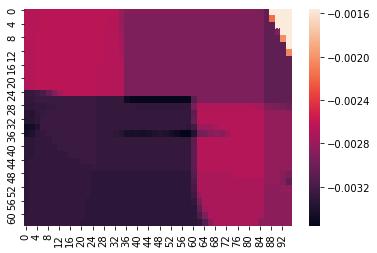

In [33]:
sns.heatmap(Xtest_df)

##### As before, visualize the matrix in dtaframe format:

In [248]:
Xtest_df = Xtest_df.stack().reset_index(name='quality_rating').rename(columns={'level_0':r'$\eta$','level_1':r'$\phi$','quality_rating':'quality_rating'})
display(Xtest_df)

,$\eta$,$\phi$,quality_rating
0,0,0,0.000307
1,0,1,0.000307
2,0,2,0.000367
3,0,3,0.000367
4,0,4,0.000368
...,...,...,...
6139,63,91,0.000316
6140,63,92,0.000338
6141,63,93,0.000338
6142,63,94,0.000339


### References for writing:
- The weight matrix is initialized with random values: https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/
- Math behind neural networks: https://towardsdatascience.com/https-medium-com-piotr-skalski92-deep-dive-into-deep-networks-math-17660bc376ba
- for help with the model : https://towardsdatascience.com/a-compact-cnn-for-weakly-supervised-textured-surface-anomaly-detection-2572c3a65b80

##### Attempt 3:

In [26]:
# from keras.applications import VGG16
# from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.mixture import GaussianMixture

In [17]:
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [59]:
#add the two 0 channels
X = np.append(X,np.zeros((20,65,99,1)),axis=3)
X = np.append(X,np.zeros((20,65,99,1)),axis=3)
X.shape

(20, 65, 99, 3)

In [311]:
# vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(64, 98, 3))
# for layer in vgg_conv.layers:
#      layer.trainable = False
# vgg_conv.summary()

# last_layer = vgg_conv.get_layer('block2_conv2')
# last_output = last_layer.output

# x = layers.InputLayer(input_shape=(X.shape[1],X.shape[2],1))(last_output[:,:,:,0:1])
# x = layers.UpSampling2D()(x)
# x = layers.Dense(units=1,activation='sigmoid')(x)
# model = Model(inputs=vgg_conv.input, outputs=x)

# model.summary()
model = Sequential()
model.add(Input(shape=(64,98,1,)))
# model.add(InputLayer(input_shape=(X.shape[1],X.shape[2],1)))
model.add(DepthwiseConv2D(64,(2,2), activation='tanh', padding='same'))
model.add(layers.ReLU(0.2))
model.add(Dropout(0.2))
model.add(UpSampling2D())
# model.add(UpSampling2D())
# model.add(DepthwiseConv2D(32,(2,2), activation='tanh', padding='same'))
# model.add(layers.ReLU(0.2))
# model.add(Dropout(0.2))
# model.add(UpSampling2D())
model.add(Dense(units=1,activation='sigmoid'))

In [ ]:
#add the two 0 channels
X = np.append(X,np.zeros((20,65,99,1)),axis=3)
X = np.append(X,np.zeros((20,65,99,1)),axis=3)
X.shape

In [86]:
#add the two 0 channels
Y = np.append(Y,np.zeros((20,65,99,1)),axis=3)
Y = np.append(Y,np.zeros((20,65,99,1)),axis=3)
Y.shape

(20, 65, 99, 3)

In [89]:
#add the two 0 channels
X2 = np.append(X2,np.zeros((8,65,99,1)),axis=3)
X2 = np.append(X2,np.zeros((8,65,99,1)),axis=3)
X2.shape

(8, 65, 99, 3)

In [90]:
#add the two 0 channels
Y2 = np.append(Y2,np.zeros((8,65,99,1)),axis=3)
Y2 = np.append(Y2,np.zeros((8,65,99,1)),axis=3)
Y2.shape

(8, 65, 99, 3)

In [235]:
X = X[:,:64,:98,:]
Y = Y[:,:64,:98,:]
X2 = X2[:,:64,:98,:]
Y2 = Y2[:,:64,:98,:]

In [327]:
# from tensorflow.keras.optimizers import RMSprop
# def adam_optimizer():
#     return Adam(lr = 0.001, beta_1=0.99, beta_2=0.999)
# model.compile(loss='mape', optimizer = adam_optimizer(), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer = RMSprop(lr=0.0001), metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer = adam_optimizer(), metrics=['accuracy'])
model.fit(x=X[:,:,:,0:1], y=Y[:,:,:,0:1],validation_data=(X2[:,:,:,0:1],Y2[:,:,:,0:1]),batch_size=2, epochs=5)
model.summary()

Train on 20 samples, validate on 8 samples
Epoch 1/5
20/20 [==============================] - 6s 323ms/sample - loss: 0.6778 - accuracy: 0.6000 - val_loss: 0.7550 - val_accuracy: 0.2500
Epoch 2/5
20/20 [==============================] - 5s 238ms/sample - loss: 0.6779 - accuracy: 0.6000 - val_loss: 0.7550 - val_accuracy: 0.2500
Epoch 3/5
20/20 [==============================] - 5s 238ms/sample - loss: 0.6777 - accuracy: 0.6000 - val_loss: 0.7551 - val_accuracy: 0.2500
Epoch 4/5
20/20 [==============================] - 5s 238ms/sample - loss: 0.6778 - accuracy: 0.6000 - val_loss: 0.7551 - val_accuracy: 0.2500
Epoch 5/5
20/20 [==============================] - 5s 237ms/sample - loss: 0.6775 - accuracy: 0.6000 - val_loss: 0.7551 - val_accuracy: 0.2500
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
depthwise_conv2d_57 (Depthwi (None, 32, 49, 1)         4097      
_____________________

In [328]:
features = model.predict(X[:,:,:,0:1]) #train_pred
# test_pred - model.predict(X2)

In [329]:
features.shape

(20, 64, 98, 1)

In [330]:
features[0,:,:,0]

array([[0.44444245, 0.44444245, 0.44444245, ..., 0.44444245, 0.44444245,
        0.44444245],
       [0.44444245, 0.44444245, 0.44444245, ..., 0.44444245, 0.44444245,
        0.44444245],
       [0.44444245, 0.44444245, 0.44444245, ..., 0.44444245, 0.44444245,
        0.44444245],
       ...,
       [0.44444245, 0.44444245, 0.44444245, ..., 0.44444245, 0.44444245,
        0.44444245],
       [0.44444245, 0.44444245, 0.44444245, ..., 0.44444245, 0.44444245,
        0.44444245],
       [0.44444245, 0.44444245, 0.44444245, ..., 0.44444245, 0.44444245,
        0.44444245]], dtype=float32)

In [331]:
pd.DataFrame(features[0,:,:,0])

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
1,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
2,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
3,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
4,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
60,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
61,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442
62,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,...,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442,0.444442


<AxesSubplot:>

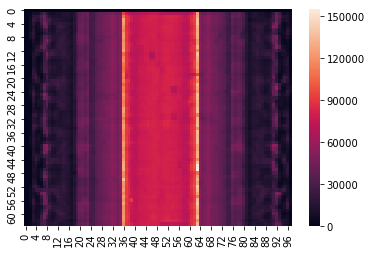

In [332]:
sns.heatmap(pd.DataFrame(X[0,:,:,0]))

<AxesSubplot:>

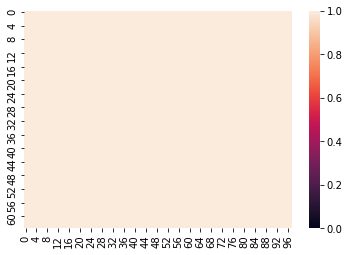

In [333]:
sns.heatmap(pd.DataFrame(Y[0,:,:,0]),vmin=0,vmax=1)

<AxesSubplot:>

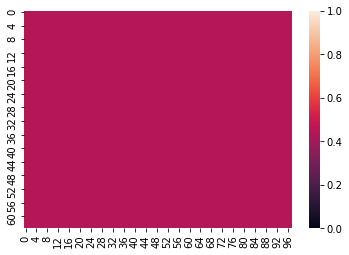

In [334]:
sns.heatmap(pd.DataFrame(features[0,:,:,0]),vmin=0,vmax=1)

In [ ]:
OKscore = gmm.score_samples(features)
thred = OKscore.mean() - 3 * OKscore.std()

test_features = model.predict(x_test)
score = gmm.score_samples(test_features)

print('normal accuracy: %.2f' % (len(score[(y_test == 1) & (score > thred)]) / 1135))
print('abnormal accuracy: %.2f' % (len(score[(y_test == 7) & (score < thred)]) / 1028))

In [ ]:
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])
plt.plotrange(len(x_test), [thred]*len(x_test), c='black')

##### UPDATE 7-24-21:
- I have a strong suspicion that the data itself is confonding the results
1. We need MORE DATA than just 20 training samples and 8 testing samples...so I need to extract and prepare those
2. We need DETAILED LABELLING of GOOD/BAD values
We can start with #2 on this list and see how it affects the results ...the model itself could be being a pain in the ass but I find that unlikely. How is there supposed to be a pattern if the same datapoints that are good are labelled as bad. This absolutely confuses the model so we instead need to use Y and Y2 not as a simple white wash BAD/GOOD instance, but we need to use it as a "binary mask" that locates the Regions of Interest(ROI) as it is called in image processing.
- Sawyer mentioned that we can generally use the statistical method (bins diff than average or whatever, see picture in phone) to determine if the value is likely to be good/bad based on the value given from this measure. Using such a tool to create the binary mask is <b>HUGELY IMPORTANT TO MENTION IN THE CONSTRUCTION OF THE OVERALL MODEL</b>. Likewise, it should be mentioned if/when we create the mask in its first phase from this formula, <b>if we augment the binary mask beyond to better highlight regions of interest</b>
- Then, it is just a matter of making sure I am using the binary mask in the right way within the model (target values as Y/Y2)